# RAG graph workflow guide

1. naive rag workflow 설명
2. customization

# Naive RAG workflow 설명
## 주피터 노트북 전용 환경 설정

In [1]:
import sys
import os

# root 프로젝트 폴더 경로를 환경 변수에 등록
PROJECT_ROOT = os.path.abspath('..')
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
print(f"Project Root: {PROJECT_ROOT}")

Project Root: /data/aisvc_data/RAG/Rag_Standard_v2


## `naive_rag_workflow.yaml` 설정 파일 상세 설명

RAG 워크플로우는 `naive_rag_workflow.yaml` 설정 파일을 통해 다양한 구성 요소를 제어합니다. 이 섹션에서는 주요 설정 항목들에 대해 설명합니다.

---

```yaml
# ---- 프로젝트 설정 ----
project_name: "Naive RAG 표준화 데모"
description: "RAG 표준화 데모용"

# --- 그래프 선택 및 빌드 ---
graph_settings:
  module: "rag_standard.graph_workflow.graph" 
  builder_function: "build_naive_rag_graph"
  # builder_args: {} # 필요시 빌더 함수에 전달할 인자

# --- 토크나이저 설정 (선택된 그래프/노드에 필요한 경우) ---
tokenizer:
  type: "KiwiTokenizer" 
  included_pos_tags:
    - NNG 
    - NNP 
    - VV  
    - VA  
  dictionary_path: "" 

# --- 노드 또는 파이프라인 특정 설정 ---
graph_node_config:
  vector_db_search: 
    index_name: "rag_sample_project" 
    dense_vector_field: "text_dense" 
    sparse_vector_field: "text_sparse_kiwi" 
    k: 10 
    size: 5 
    search_type: "hybrid" 
    hybrid_search_config:
      normalization: "min_max" 
      combination: "arithmetic_mean" 
      weights: [0.3, 0.7]

  generate_answer: 
    system_prompt_template: "너는 T3Q 회사의 AI 비서이다. 사용자의 질문에 대해 문서를 참고하여 친절하고 정확하게 답변해야 한다."
    user_prompt_template: |
      ## 사용자 질문:
      {user_query}

      ## 참고 문서:
      {documents}

      ## 답변:
    temperature: 0.7 
    stream_output: true 

# --- 평가 스크립트 설정 ---
evaluation_settings:
  qa_dataset_path: "data/QA/qa_dataset.parquet" 
  results_output_dir: "benchmark" 
  eval_type: "retrieval"  
  k_retrieval: 5 
```

---

### 1. 프로젝트 설정 (`project_name`, `description`)
- `project_name`: 프로젝트의 이름을 지정합니다.
- `description`: 프로젝트에 대한 간략한 설명을 제공합니다.

### 2. 그래프 선택 및 빌드 (`graph_settings`)
- `module`: LangGraph 그래프 빌더 함수가 포함된 파이썬 모듈의 경로를 지정합니다. (예: `rag_standard.graph_workflow.graph`)
- `builder_function`: `module` 내에서 호출할 그래프 빌더 함수의 이름을 지정합니다. (예: `build_naive_rag_graph`)
- `builder_args` (선택 사항): `builder_function`에 전달할 인자를 딕셔너리 형태로 지정합니다.

### 3. 토크나이저 설정 (`tokenizer`)
Sparse 검색 또는 특정 노드에서 텍스트 토큰화가 필요한 경우 사용됩니다.
- `type`: 사용할 토크나이저 클래스의 이름을 지정합니다. (현재 예시: `KiwiTokenizer`)
- `included_pos_tags`: `KiwiTokenizer`와 같은 형태소 분석기 기반 토크나이저에서 추출할 품사 태그 목록을 지정합니다.
- `dictionary_path`: 사용자 정의 사전 파일의 경로를 지정합니다. (프로젝트 루트 기준 상대 경로 또는 절대 경로)

### 4. 노드 또는 파이프라인 특정 설정 (`graph_node_config`)
LangGraph의 각 노드에서 `state['config']['graph_node_config']`를 통해 접근할 수 있는 설정입니다.

#### 4.1. `vector_db_search` 노드 설정
- `index_name`: OpenSearch에서 사용할 인덱스 이름을 지정합니다.
- `dense_vector_field`: Dense 벡터가 저장된 OpenSearch 인덱스 필드명을 지정합니다.
- `sparse_vector_field`: Sparse 벡터(토큰)가 저장된 OpenSearch 인덱스 필드명을 지정합니다.
- `k`: KNN 검색 시 초기 검색할 문서의 수를 지정합니다.
- `size`: 최종적으로 반환할 문서의 수를 지정합니다.
- `search_type`: 검색 유형을 지정합니다. (`dense`, `sparse`, `hybrid` 중 선택)
- `hybrid_search_config` (search_type이 `hybrid`일 경우):
  - `normalization`: 하이브리드 검색 시 스코어 정규화 방식을 지정합니다. (`min_max`, `l2` 등)
  - `combination`: 정규화된 스코어를 결합하는 방식을 지정합니다. (`arithmetic_mean`, `geometric_mean`, `harmonic_mean` 등)
  - `weights`: Dense 검색과 Sparse 검색 결과의 가중치를 리스트 형태로 지정합니다. (예: `[0.3, 0.7]`)

#### 4.2. `generate_answer` 노드 설정
- `system_prompt_template`: LLM에 전달할 시스템 프롬프트 템플릿을 지정합니다.
- `user_prompt_template`: LLM에 전달할 사용자 프롬프트 템플릿을 지정합니다. `{user_query}`와 `{documents}` 변수를 포함할 수 있습니다.
- `temperature`: LLM 호출 시 사용할 `temperature` 파라미터 값을 지정합니다.
- `stream_output`: LLM의 답변을 스트리밍 형태로 받을지 여부를 지정합니다. (`true` 또는 `false`)

### 5. 평가 스크립트 설정 (`evaluation_settings`)
`scripts/run_evaluation.py` 스크립트 실행 시 사용되는 설정입니다.
- `qa_dataset_path`: 평가에 사용할 QA 데이터셋(Parquet 형식) 파일 경로를 지정합니다. (프로젝트 루트 기준)
- `results_output_dir`: 평가 결과가 저장될 디렉토리 경로를 지정합니다. (프로젝트 루트 기준)
- `eval_type`: 수행할 평가 유형을 지정합니다. (`retrieval`, `generation`, `all` 중 선택)
- `k_retrieval`: 검색 성능 지표(Precision@k, Recall@k, F1@k) 계산 시 사용할 `k` 값을 지정합니다.

---

## `execute_rag_pipeline()` 살펴보기

`scripts/run_graph_workflow.py`에 있는 `execute_rag_pipeline`은 langgraph workflow를 실행하는 함수입니다.   
`scripts/cli_chat`, `scripts/run_evaluation`에서도 사용됩니다.

**실행 과정**
1. `yaml config`에 정의된 `토크나이저` 결정
2. `.env`에 정의된 opensearch host, port로 `OpensearchManager`(+하이브리드 검색 파이프라인) 결정
3. `rag_standard/graph_workflow`에 정의된 그래프 워크플로우 import 및 실행

그래프 워크플로우 및 rag pipeline 코드는 얼마든지 **커스텀**하셔서 사용하시면 됩니다.

```python
def execute_rag_pipeline(
    pipeline_config: dict, 
    user_query: str,
    opensearch_manager_instance: OpenSearchManager = None, # 파라미터 이름 및 타입 변경
    tokenizer_instance = None,
    runnable_graph_instance = None 
    ) -> dict:
    """
    주어진 설정과 사용자 질문으로 RAG 파이프라인을 실행하고 최종 상태를 반환합니다.
    OpenSearch Manager, 토크나이저, 그래프를 외부에서 주입받아 재사용할 수 있습니다.

    Args:
        pipeline_config (dict): 파이프라인 설정입니다.
        user_query (str): 사용자의 질문입니다.
        opensearch_manager_instance (OpenSearchManager, optional): 미리 초기화된 OpenSearchManager 인스턴스입니다.
        tokenizer_instance (object, optional): 미리 초기화된 토크나이저입니다.
        runnable_graph_instance (Any, optional): 미리 빌드된 LangGraph 실행 가능 객체입니다.

    Returns:
        dict: 파이프라인 실행 후의 최종 상태(state)입니다. 오류 발생 시 'error' 키를 포함할 수 있습니다.
    """
    print(f"\n--- RAG 파이프라인 실행 시작 (질문: '{user_query}') ---")

    # 1. 토크나이저 결정 (주입 또는 신규 초기화)
    current_tokenizer = tokenizer_instance
    if not current_tokenizer:
        current_tokenizer = initialize_tokenizer_from_config(pipeline_config)
    else:
        print("기존 토크나이저 인스턴스를 사용합니다.")
        
    # 2. OpenSearch Manager 결정 (주입 또는 신규 초기화)
    current_opensearch_manager = opensearch_manager_instance # 변수 이름 변경
    if not current_opensearch_manager:
        current_opensearch_manager = initialize_opensearch_manager_with_globals() # 변수 이름 변경
    else:
        print("기존 OpenSearch Manager 인스턴스를 사용합니다.") # 메시지 변경
    
    ## 하이브리드 검색일 경우) YAML에 정의된 검색 파이프라인 생성/업데이트 시도
    vector_db_search_config = pipeline_config.get('graph_node_config', {}).get('vector_db_search', {})
    if vector_db_search_config.get('search_type') == 'hybrid':
        hybrid_search_config = vector_db_search_config.get('hybrid_search_config', {})

        if hybrid_search_config:
            normalization = hybrid_search_config['normalization']
            combination = hybrid_search_config['combination']
            weights = hybrid_search_config['weights']

            hybrid_search_pipeline_name = f"{normalization}_{combination}_{'_'.join([str(int(w*10)) for w in weights])}"

            print(f"\n--- '{hybrid_search_pipeline_name}' 검색 파이프라인 준비 중 (YAML 정의 사용) ---")
            
            if current_opensearch_manager.check_search_pipeline(hybrid_search_pipeline_name): # 파이프라인이 존재하면 그대로 사용
                print(f"--- '{hybrid_search_pipeline_name}' 검색 파이프라인이 존재하므로 생성하지 않습니다. ---")
            else: # 파이프라인이 존재하지 않으면 생성
                try:
                    current_opensearch_manager.create_search_pipeline(hybrid_search_pipeline_name, normalization, combination, weights)
                    # create_search_pipeline 내부에서 성공/실패 로그를 이미 출력합니다.
                    print(f"--- '{hybrid_search_pipeline_name}' 검색 파이프라인 준비 완료 ---")
                except Exception as e:
                    print(f"경고: '{hybrid_search_pipeline_name}' 검색 파이프라인 생성/업데이트 실패: {e}. 계속 진행합니다.")
                    # 파이프라인 생성 실패 시, 기존에 파이프라인이 존재하면 검색은 성공할 수 있음
                    # 또는 여기서 워크플로우를 중단하도록 선택할 수도 있습니다.
                    print(f"--- '{hybrid_search_pipeline_name}' 검색 파이프라인 준비 실패 ---")


    # 3. 실행 가능한 RAG 그래프 결정 (주입 또는 신규 빌드)
    current_runnable_graph = runnable_graph_instance
    if not current_runnable_graph:
        print("새로운 그래프 인스턴스를 빌드합니다...")
        try:
            current_runnable_graph = get_graph_runnable_from_config(pipeline_config)
        except Exception as e:
            return {
                "error": f"그래프 빌드 실패: {str(e)}", 
                "llm_answer": "오류로 인해 답변을 생성할 수 없습니다."
            }
    else:
        print("기존 그래프 인스턴스를 사용합니다.")

    # 4. 초기 상태 준비
    initial_state = {
        'user_query': user_query,
        'config': pipeline_config,
        'sparse_tokenizer': current_tokenizer, 
        'opensearch_manager': current_opensearch_manager, # 키 이름 변경: opensearch_client -> opensearch_manager
        'llm_stream_handled_by_node': False
    }
    print("파이프라인 초기 상태가 준비되었습니다.")

    # 5. 그래프 실행
    try:
        print("LangGraph 그래프 실행 중...")
        final_state = current_runnable_graph.invoke(initial_state)
        print("RAG 파이프라인 실행 성공.")
        print("--- RAG 파이프라인 실행 완료 ---")
        return final_state
    except Exception as e:
        print(f"RAG 파이프라인 실행 중 오류 발생: {e}")
        print("--- RAG 파이프라인 실행 실패 ---")
        return {
            "error": f"파이프라인 실행 오류: {str(e)}", 
            "llm_answer": f"파이프라인 실행 중 오류로 인해 답변을 생성할 수 없습니다: {e}"
        }
```

---

## Hybrid Search Pipeline in OpenSearch

Opensearch에서 하이브리드 검색은 serach pipeline이 등록되어야 사용할 수 있습니다.

### 설정 (`naive_rag_workflow.yaml`)

`naive_rag_workflow.yaml` 파일 내 `graph_node_config.vector_db_search` 섹션에서 하이브리드 검색 파이프라인을 설정합니다:

```yaml
graph_node_config:
  vector_db_search:
    index_name: "rag_sample_project"
    dense_vector_field: "text_dense"
    sparse_vector_field: "text_sparse_kiwi"
    k: 10
    size: 5
    search_type: "hybrid" # <--- 하이브리드 검색 사용 명시
    hybrid_search_config:
      normalization: "min_max"        # 스코어 정규화 방식 (예: min_max, l2)
      combination: "arithmetic_mean"  # 스코어 결합 방식 (예: arithmetic_mean, geometric_mean)
      weights: [0.3, 0.7]             # Dense 검색과 Sparse 검색 결과의 가중치 [dense_weight, sparse_weight]
```

- `normalization`: 각 검색 결과의 스코어 범위를 통일합니다.
- `combination`: 정규화된 스코어들을 결합하여 최종 스코어를 계산합니다.
- `weights`: 각 검색 방식의 중요도를 조절합니다.

### 파이프라인 자동 관리
`scripts/run_graph_workflow.py`의 `execute_rag_pipeline` 함수는 워크플로우 실행 시 YAML 설정을 기반으로 OpenSearch에 해당 하이브리드 검색 파이프라인이 존재하는지 확인하고, 없으면 자동으로 생성/업데이트합니다.

- **파이프라인 이름 규칙**: `hybrid_search_config`의 `normalization`, `combination`, `weights` 값을 조합하여 `f"{normalization}_{combination}_{weight_dense*10}_{weight_sparse*10}"` 형식의 파이프라인 이름을 사용합니다. (예: `min_max_arithmetic_mean_3_7`)

- **관련 모듈**:
  - `rag_standard/utils/opensearch_manager.py`: `check_search_pipeline`, `create_search_pipeline` 메서드를 통해 파이프라인을 관리합니다.
  - `rag_standard/graph_workflow/node.py`: `vector_db_search` 노드에서 `execute_hybrid_search_with_pipeline`을 호출하여 하이브리드 검색을 실행합니다.

## workflow graph 내부 살펴보기

```python
# build_naive_rag_graph 정의(rag_standard/graph_workflow/graph.py)

from langgraph.graph import StateGraph, START, END
from rag_standard.graph_workflow.state import NaiveRAGState
from rag_standard.graph_workflow.node import vector_db_search, generate_answer

# 참고: utils.opensearch_client.init_opensearch_client 와 utils.config_setting.load_env 는
# 이 모듈을 직접 사용하는 대신, 실행 스크립트(예: run_graph_workflow.py)에서 관리됩니다.

def build_naive_rag_graph():
    """
    표준 Naive RAG 그래프를 생성하고 컴파일하는 함수입니다.
    이 함수는 설정 파일의 'graph_settings'에 따라 동적으로 호출될 수 있습니다.
    """
    graph = StateGraph(NaiveRAGState)

    # 그래프에 노드(Node) 추가
    graph.add_node('vector_db_search', vector_db_search) # 벡터 DB 검색 노드
    graph.add_node('generate_answer', generate_answer)   # 답변 생성 노드

    # 그래프에 엣지(Edge) 추가 (노드 간의 흐름 정의)
    graph.add_edge(START, 'vector_db_search')             # 시작점에서 vector_db_search 노드로 이동
    graph.add_edge('vector_db_search', 'generate_answer') # vector_db_search 노드에서 generate_answer 노드로 이동
    graph.add_edge('generate_answer', END)                # generate_answer 노드에서 종료점으로 이동

    # 그래프 컴파일
    compiled_graph = graph.compile()
    print("Naive RAG 그래프가 빌드 및 컴파일되었습니다.")
    return compiled_graph

# 만약 다른 종류의 그래프 빌더 함수가 있다면 여기에 추가합니다.
# 예: def build_advanced_rag_graph(custom_param1: str): ...
```

Naive RAG 그래프가 빌드 및 컴파일되었습니다.


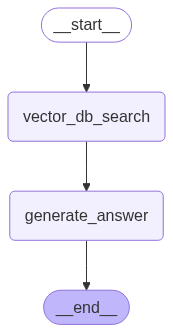

In [2]:
from rag_standard.graph_workflow.graph import build_naive_rag_graph

naive_rag_graph = build_naive_rag_graph()
naive_rag_graph

naive graph는 두가지 노드가 존재합니다.
1. `vector_db_search`: 벡터 디비 검색
2. `generate_answer`: 검색된 문서와 사용자 질문으로 프롬프트 구성 후 LLM으로 답변 생성

노드 내부도 프로젝트에 따라 **커스텀**하시면 됩니다!

그래프 상태는 다음과 같이 정의되어 있습니다. (`rag_standard/graph_workflow/state.py`)
- `config`: `naive_rag_workflow.yaml` 파일
- `user_query`: 사용자 질문
- `sparse_tokenizer`: `KiwiTokenizer`같은 sparse 검색용 토크나이저
- `opensearch_manager`: `rag_standard/utils/opensearch_manager.py`에 정의된 오픈서치 매니저
- `retrieved_documents`: 오픈서치 검색 결과
- `llm_answer`: LLM 답변
- `llm_stream_handled_by_node`: 스트리밍으로 답변했는지 아닌지 여부
  - 스트리밍 답변이 아니면 원래 `script/` 하위에 있는 파이썬 파일들에서 처리하지만, 스트리밍 답변이면 `generate_answer` 노드에서 바로 처리리

`sparse_tokenizer`와 `opensearch_manager` 타입이 `Any`인 이유: 그래프 출력해서 mermaid_png로 보고싶을 때 원래 타입 쓰면 에러 발생...


In [ ]:
from typing import TypedDict, List, Dict, Any, Optional
# from rag_standard.utils.sparse_tokenizer import SparseTokenizer
# from rag_standard.utils.opensearch_manager import OpenSearchManager

# Naive RAG State 정의
class NaiveRAGState(TypedDict):
  config: Dict # 파이프라인 설정
  user_query: str # 사용자 질문
  sparse_tokenizer: Any # SparseTokenizer
  opensearch_manager: Any # OpenSearchManager
  retrieved_documents: List[dict] # 검색 결과
  llm_answer: str # LLM 답변
  # 스트리밍이 노드 레벨에서 처리되었는지 여부를 나타내는 플래그 (선택 사항)
  llm_stream_handled_by_node: Optional[bool] 

NaiveRAGState 구성을 바꾸거나   
새로운 State를 해당 파이썬 파일에 추가해나가시면 됩니다!

노드는 다음과 같이 정의되어 있습니다 (`rag_standard/graph_workflow/node.py`)

In [ ]:
# rag_standard/graph_workflow/node.py
from rag_standard.utils.model_call import embed_text, generate_llm_response
from rag_standard.graph_workflow.state import NaiveRAGState
# from rag_standard.utils.opensearch_manager import OpenSearchManager # 타입 힌팅을 위해 필요할 수 있음
import sys # 스트리밍 출력을 위해 추가

def vector_db_search(state: NaiveRAGState) -> NaiveRAGState:
    """
    벡터 데이터베이스 검색을 수행하고 결과를 state['retrieved_documents']에 저장합니다.
    state['opensearch_manager']를 사용하여 검색 로직을 실행합니다.
    state['config']['graph_node_config']['vector_db_search']['search_type']에 따라 검색 유형이 결정됩니다.
    """
    print('='*30)
    print("노드 실행: vector_db_search")
    search_cfg = state['config']['graph_node_config']['vector_db_search']
    opensearch_manager = state['opensearch_manager'] # OpenSearchManager 인스턴스를 가져옵니다.

    index_name = search_cfg['index_name']
    size = search_cfg['size']
    # _source 제외 필드 설정 (dense와 sparse 필드 모두 기본적으로 제외 시도)
    source_excludes = [search_cfg.get('dense_vector_field'), search_cfg.get('sparse_vector_field')]
    source_excludes = [f for f in source_excludes if f is not None] # None 값 제거

    search_type = search_cfg['search_type']
    response = None

    if search_type == 'dense':
        query_embedding = embed_text([state['user_query']])[0]
        response = opensearch_manager.execute_dense_search(
            index_name=index_name,
            query_vector=query_embedding,
            dense_field=search_cfg['dense_vector_field'],
            k=search_cfg['k'],
            size=size,
            source_excludes=source_excludes
        )
    elif search_type == 'sparse':
        tokenized_query = state['sparse_tokenizer'].tokenize(state['user_query'])
        response = opensearch_manager.execute_sparse_search(
            index_name=index_name,
            tokenized_query=tokenized_query,
            sparse_field=search_cfg['sparse_vector_field'],
            size=size,
            source_excludes=source_excludes
        )
    elif search_type == 'hybrid':
        tokenized_query = state['sparse_tokenizer'].tokenize(state['user_query'])
        query_embedding = embed_text([state['user_query']])[0]

        hybrid_search_config = search_cfg['hybrid_search_config']
        normalization = hybrid_search_config['normalization']
        combination = hybrid_search_config['combination']
        weights = hybrid_search_config['weights']
        hybrid_search_pipeline_name = f"{normalization}_{combination}_{'_'.join([str(int(w*10)) for w in weights])}"
        
        response = opensearch_manager.execute_hybrid_search_with_pipeline(
            index_name=index_name,
            pipeline_name=hybrid_search_pipeline_name,
            query_vector=query_embedding,
            dense_field=search_cfg['dense_vector_field'],
            k_dense=search_cfg['k'], # 'k'는 dense 검색의 k로 사용
            tokenized_query=tokenized_query,
            sparse_field=search_cfg['sparse_vector_field'],
            size=size,
            source_excludes=source_excludes
        )
    else:
        # opensearch_manager의 로그와는 별개로, 노드 레벨에서도 오류를 명확히 발생시킵니다.
        raise ValueError(f"지원되지 않는 검색 유형입니다: {search_type}. 'dense', 'sparse', 'hybrid' 중 하나여야 합니다.")

    state['retrieved_documents'] = response['hits']['hits']
    print(f"vector_db_search: {len(state['retrieved_documents'])}개의 문서를 검색했습니다.")
    return state

def generate_answer(state: NaiveRAGState) -> NaiveRAGState:
    """
    검색된 문서를 사용하여 LLM으로부터 답변을 생성합니다.
    결과는 state['llm_answer']에 저장되며, 설정에 따라 스트리밍 출력을 합니다.
    """
    print('='*30)
    print("노드 실행: generate_answer")
    llm_cfg = state['config']['graph_node_config']['generate_answer']
    
    # 검색된 문서가 없는 경우 처리
    if not state.get('retrieved_documents'):
        print("generate_answer: 검색된 문서가 없어 답변 생성을 건너뜁니다.")
        state['llm_answer'] = llm_cfg.get('no_documents_found_answer', "죄송합니다, 관련된 정보를 찾지 못했습니다.")
        state['llm_stream_handled_by_node'] = False # 스트리밍을 하지 않았으므로 False
        return state

    # 문서 포맷팅
    documents_formatted = []
    for doc in state['retrieved_documents']:
        source = doc.get('_source', {})
        file_name = source.get('file_name', '알 수 없는 파일')
        # retrieve_content 대신 text_content 또는 다른 필드 이름을 사용할 수 있으므로 설정에서 가져오도록 고려 가능
        content = source.get(llm_cfg.get('document_content_field', 'retrieve_content'), '내용 없음')
        documents_formatted.append(f'# {file_name}\n\n{content}')
    
    documents_string = "\n\n---\n\n".join(documents_formatted)

    system_prompt = llm_cfg.get('system_prompt_template', "너는 T3Q 회사의 AI 비서야. 사용자의 질문에 대해 친절하고 정확하게 답변해야 해.")
    user_prompt_template = llm_cfg.get('user_prompt_template', """다음은 사용자의 질문과 관련된 문서들이야. 이 문서들을 참고해서 사용자의 질문에 답변해줘.
    문서에 명시적으로 언급되지 않은 내용은 답변에 포함하지 마.

    [사용자 질문]
    {user_query}

    [참고 문서]
    {documents}""")
    
    user_prompt = user_prompt_template.format(user_query=state['user_query'], documents=documents_string)

    should_stream_output = llm_cfg.get('stream_output', False)
    accumulated_response_strings = []

    llm_params = {
        "temperature": llm_cfg.get('temperature', 0.7),
        "top_p": llm_cfg.get('top_p', 0.8),
        "top_k": llm_cfg.get('top_k', 20),
        "repetition_penalty": llm_cfg.get('repetition_penalty', 1.05)
    }

    print("="*15, f"generate_answer: LLM 호출 시작 (스트리밍: {should_stream_output})", "="*15)
    if should_stream_output:
        response_generator = generate_llm_response(
            system_prompt=system_prompt, 
            user_prompt=user_prompt, 
            stream=True, 
            **llm_params
        )
        # 스트리밍 응답 처리: generate_llm_response가 다양한 LLM SDK의 청크를 반환할 수 있으므로,
        # 아래 로직은 일반적인 경우를 다루려고 시도합니다.
        # model_call.py의 generate_llm_response가 반환하는 청크의 정확한 구조에 맞춰 조정하는 것이 가장 좋습니다.
        for chunk_obj in response_generator:
            content_piece = None
            if hasattr(chunk_obj, 'choices') and chunk_obj.choices and \
               hasattr(chunk_obj.choices[0], 'delta') and \
               hasattr(chunk_obj.choices[0].delta, 'content'):
                content_piece = chunk_obj.choices[0].delta.content # OpenAI 유사 API
            elif hasattr(chunk_obj, 'text'): # 일부 API는 chunk.text로 제공
                content_piece = chunk_obj.text
            elif isinstance(chunk_obj, str): # 이미 문자열로 반환되는 경우
                content_piece = chunk_obj
            # 여기에 다른 LLM SDK의 청크 구조에 대한 elif 조건들을 추가할 수 있습니다.
            
            if content_piece:
                print(content_piece, end='', flush=True) 
                accumulated_response_strings.append(content_piece)
            elif chunk_obj is None and not accumulated_response_strings:
                pass # 일부 모델의 초기 빈 청크는 무시

        print() # 스트리밍 완료 후 줄바꿈
        state['llm_answer'] = "".join(accumulated_response_strings)
        state['llm_stream_handled_by_node'] = True
    else:
        full_response = generate_llm_response(
            system_prompt=system_prompt, 
            user_prompt=user_prompt, 
            stream=False, 
            **llm_params
        )
        state['llm_answer'] = full_response
        state['llm_stream_handled_by_node'] = False
    
    print("="*15, "generate_answer: LLM 답변 생성 완료.", "="*15)
    return state

그래프 직접 실행해보기

In [ ]:
import os
from rag_standard.utils.config_setting import load_yaml_config, load_env
from rag_standard.utils.sparse_tokenizer import KiwiTokenizer
from rag_standard.utils.opensearch_manager import OpenSearchManager

load_env()

user_query = 'CTP CTQ가 뭐야?'
pipeline_config = load_yaml_config(os.path.abspath('../configs/naive_rag_workflow.yaml'))
sparse_tokenizer = KiwiTokenizer(included_pos_tags=pipeline_config['tokenizer']['included_pos_tags'])

host = os.getenv("OPENSEARCH_HOST")
port = os.getenv("OPENSEARCH_PORT")
opensearch_manager = OpenSearchManager(host=host, port=port)

initial_state = {
        'user_query': user_query,
        'config': pipeline_config,
        'sparse_tokenizer': sparse_tokenizer, 
        'opensearch_manager': opensearch_manager, # 키 이름 변경: opensearch_client -> opensearch_manager
        'llm_stream_handled_by_node': True
}
naive_rag_graph.invoke(initial_state)

(랭그래프 문법 참조 후)   
노드 내부 구현을 바꾸시거나   
새로운 노드들을 추가해나가면서   
그래프 워크플로우를 개선해나가면 됩니다!

# RAG 파이프라인 평가 (`scripts/run_evaluation.py`)

`scripts/run_evaluation.py` 스크립트를 통해 RAG 파이프라인의 검색(Retrieval) 및 생성(Generation) 성능을 체계적으로 평가할 수 있습니다!   
하지만 생성보다는 검색 평가가 더 효과가 크기 때문에 검색 평가에 집중합니다.

## 평가 설정 (`naive_rag_workflow.yaml`)

`naive_rag_workflow.yaml` 파일의 `evaluation_settings` 섹션에서 평가 관련 설정을 관리합니다:
```yaml
evaluation_settings:
  qa_dataset_path: "data/QA/qa_dataset.parquet" # QA 데이터셋 Parquet 파일 경로 (프로젝트 루트 기준)
  results_output_dir: "benchmark" # 평가 결과 저장 디렉토리 (프로젝트 루트 기준)
  eval_type: "retrieval"  # 수행할 평가 유형: 'retrieval', 'generation', 또는 'all'
  k_retrieval: 5 # 검색 성능 지표(P@k, R@k, F1@k) 계산 시 사용할 k값
```

## QA 데이터셋 형식
평가에는 **Parquet** 형식의 QA 데이터셋이 사용됩니다.

- 필수 컬럼:
  - `query_id` `(str, optional)`: 각 질문의 고유 ID. 지정하지 않으면 순번으로 자동 생성됩니다.
  - `query` `(str)`: 사용자 질문.
  - `ground_truth_retrieved_doc_ids` `(List[str] 또는 Set[str])`: 정답 문서 ID 목록 (검색 평가용). `run_evaluation.py`에서 문자열 세트(Set[str])로 변환하여 사용합니다.
  - `ground_truth_answers` `(List[str])`: 정답 답변 목록 (생성 평가용). `run_evaluation.py`에서 문자열 리스트(List[str])로 변환하여 사용합니다.

- 데이터셋 경로: `qa_dataset_path`에 지정된 경로는 프로젝트 루트를 기준으로 합니다.

In [ ]:
# 예시
import pandas as pd

test_dataset = [
    {
        "id": "qa_1",
        "query": "국방혁신 4.0 기본계획의 주요 내용은 무엇인가요?",
        "ground_truth_retrieved_doc_ids": {"01954ff18c6530a9bccc4539c75109da"},
        "ground_truth_answers": "국방혁신 4.0 기본계획은 북핵·미사일 대응능력 강화, 군사전략 발전, AI 기반 첨단전력 확보, 군구조 및 교육훈련 혁신, 국방 R&D 및 전력증강체계 재설계 등 5대 중점을 가지고 있습니다."
    },
    {
        "id": "qa_2",
        "query": "국방 AI 센터 추진팀의 설치 목적은 무엇인가요?",
        "ground_truth_retrieved_doc_ids": {"3305a14be1c0794dfda47eaa79757208"},
        "ground_truth_answers": "국방AI센터 창설과 관련한 소관 사무에 대하여 책임있고 신속하게 대응하고, 그 성과 창출을 뒷받침하기 위함입니다."
    },
    {
        "id": "qa_3", # 관련 없는 문서 ID 및 답변 예시
        "query": "오늘 날씨는 어떤가요?",
        "ground_truth_retrieved_doc_ids": {"non_existent_id_1", "non_existent_id_2"},
        "ground_truth_answers": "죄송합니다, 저는 날씨 정보를 제공할 수 없습니다."
    }
]

df = pd.DataFrame(test_dataset)
df

## 평가 실행
다음 명령어를 사용하여 평가를 실행합니다:
```bash
python scripts/run_evaluation.py configs/naive_rag_workflow.yaml
```
스크립트는 지정된 QA 데이터셋을 사용하여 각 질문에 대해 RAG 파이프라인을 실행하고, 설정된 `eval_type`에 따라 검색 및/또는 생성 성능 지표를 계산합니다.

## 평가 지표
`rag_standard/utils/evaluation_metrics.py`에 정의된 함수들을 사용하여 다음 지표들을 계산합니다:

- **검색 지표 (Retrieval Metrics)**:
  - **Precision@k**: 상위 k개 검색 결과 중 정답 문서의 비율.
  - **Recall@k**: 전체 정답 문서 중 상위 k개 검색 결과에 포함된 비율.
  - **F1@k**: Precision@k와 Recall@k의 조화 평균.
- `k` 값은 evaluation_settings.k_retrieval에서 설정합니다.

- **생성 지표 (Generation Metrics)**:
  - **ROUGE-1/2/L (F1-score)**: 생성된 답변과 정답 답변 간의 n-gram 중복 기반 유사도.
  - **BLEU**: 생성된 답변과 정답 답변 간의 n-gram 정밀도 기반 유사도 (NLTK 라이브러리 사용).

## 결과 출력
평가 결과는 `evaluation_settings.results_output_dir`에 지정된 디렉토리 (예: `benchmark/`) 하위에 각 실행별 고유 시도 번호로 생성된 폴더(예: 0, 1, 2, ...) 내에 저장됩니다.

- `detailed_evaluation_results.csv`: 각 QA 항목별 상세 평가 지표가 포함된 CSV 파일.
- `summary_metrics.csv`: 전체 QA 데이터셋에 대한 평균 평가 지표 요약 CSV 파일.

사용한 config_file의 복사본: 평가 실행 시 사용된 YAML 설정 파일의 복사본이 함께 저장되어 실험의 재현성을 높입니다.

# customization

## 공통부분 (utils) 커스텀

`rag_standard/utils/` 디렉토리에는 RAG 워크플로우 전반에서 사용되는 유틸리티 함수 및 클래스들이 포함되어 있습니다.   
프로젝트의 특정 요구사항에 맞춰 이 부분들을 커스텀할 수 있습니다.

### 주요 커스텀 대상 파일

- **`config_setting.py`**: 
  - `.env` 파일 로드 방식이나 YAML 설정 파일 처리 로직을 변경할 수 있습니다.
  - 예를 들어, 다른 설정 파일 형식을 지원하거나, 환경 변수 관리 정책을 변경할 때 수정합니다.

- **`evaluation_metrics.py`**:
  - 새로운 평가 지표를 추가하거나 기존 지표(Precision@k, Recall@k, ROUGE, BLEU 등)의 계산 방식을 수정할 수 있습니다.
  - 프로젝트 특화된 평가 기준이 있다면 여기에 구현합니다.

- **`model_call.py`**:
  - 사용하는 LLM 또는 임베딩 모델을 변경하거나, API 호출 방식(URL, 파라미터 등)을 수정할 수 있습니다.
  - 다른 모델 제공자를 사용하거나, 모델 호출 시 추가적인 로직(예: 재시도, 로깅)을 넣고 싶을 때 커스텀합니다.

- **`opensearch_manager.py`**:
  - OpenSearch 연결 방식, 인덱스 관리, 검색 쿼리 실행 로직 등을 수정할 수 있습니다.
  - OpenSearch와의 상호작용을 더 세밀하게 제어하고 싶을 때 커스텀합니다.
    - 예를 들어, `create_search_pipeline` 메서드를 수정하여 다양한 파이프라인 정의를 지원할 수 있습니다.

- **`setup_logger.py`**:
  - 로깅 포맷, 레벨, 핸들러(파일, 콘솔 등) 설정을 변경할 수 있습니다.

- **`sparse_tokenizer.py`**:
  - `KiwiTokenizer` 외의 다른 한국어 형태소 분석기나 Sparse 토큰화 방식을 사용하고 싶을 때, `SparseTokenizer` 추상 클래스를 상속받아 새로운 토크나이저를 구현할 수 있습니다.
  - 기존 `KiwiTokenizer`의 품사 태그 선택 기준이나 사용자 사전 로드 방식을 변경할 수도 있습니다.

### 주의사항
`utils` 디렉토리의 코드는 여러 스크립트와 그래프 노드에서 공유되므로, 수정 시에는 전체 워크플로우에 미치는 영향을 고려해야 합니다.   
팀원들과 충분히 상의 후 진행하는 것이 좋습니다.

---

## RAG workflow yaml 설정 파일 커스텀

`configs/naive_rag_workflow.yaml` 파일은 RAG 파이프라인의 동작을 상세하게 제어하는 핵심 설정 파일입니다.   
이미 앞선 섹션에서 각 항목에 대한 설명을 다루었지만, 여기서는 커스텀 관점에서 몇 가지 추가적인 가이드를 제공합니다.

### 1. 새로운 노드 설정 추가
만약 `rag_standard/graph_workflow/graph.py`에서 새로운 노드를 정의하고 그래프에 추가했다면, 해당 노드에 필요한 설정을 `graph_node_config` 아래에 추가할 수 있습니다.
예를 들어, `query_rewriter`라는 노드를 추가하고, 이 노드가 특정 LLM 모델과 프롬프트를 사용하도록 설정하고 싶다면 다음과 같이 추가할 수 있습니다:
```yaml
graph_node_config:
  # ... 기존 vector_db_search, generate_answer 설정 ...
  query_rewriter:
    llm_model_name: "qwen-3"
    rewrite_prompt_template: "다음 사용자 질문을 검색에 더 적합하도록 명확하게 재작성해주세요: {user_query}"
    temperature: 0.2
```
이렇게 추가된 설정은 해당 노드 내에서 `state['config']['graph_node_config']['query_rewriter']`와 같이 접근하여 사용할 수 있습니다.

### 2. 기존 노드 설정 확장
기존 노드(`vector_db_search`, `generate_answer`)의 동작을 변경하기 위해 설정을 추가하거나 수정할 수 있습니다.
- `vector_db_search`:
  - `search_type`에 따라 `dense`, `sparse`, `hybrid` 외에 새로운 검색 전략을 추가하고 관련 설정을 정의할 수 있습니다 (예: `custom_search_config`).
  - OpenSearch 외 다른 벡터 DB를 사용한다면, 해당 DB에 맞는 연결 정보나 파라미터를 추가할 수 있습니다.
- `generate_answer`:
  - `temperature`, `stream_output` 외에 LLM 호출에 필요한 다른 파라미터(예: `top_p`, `max_tokens`)를 추가하고, `rag_standard/utils/model_call.py`의 `generate_llm_response` 함수나 `rag_standard/graph_workflow/node.py`의 `generate_answer` 노드에서 이를 사용하도록 수정할 수 있습니다.
  - 문서 포맷팅 방식이나, 검색 결과가 없을 때의 기본 답변(`no_documents_found_answer`) 등을 변경할 수 있습니다.

### 3. 그래프 빌더 변경
`graph_settings`의 `module`과 `builder_function`을 수정하여 완전히 다른 구조의 RAG 그래프를 사용하도록 설정할 수 있습니다. 예를 들어, `rag_standard.graph_workflow.graph` 모듈 내에 `build_advanced_rag_graph`라는 새로운 그래프 빌더 함수를 만들었다면 다음과 같이 변경합니다:
```yaml
graph_settings:
  module: "rag_standard.graph_workflow.graph"
  builder_function: "build_advanced_rag_graph"
  # builder_args: { "custom_param": "value" } # 필요시 새 빌더 함수에 인자 전달
```

### 4. 토크나이저 및 평가 설정 커스텀
- `tokenizer`: 다른 형태소 분석기나 토큰화 라이브러리를 사용하기 위해 `type`을 변경하고, 해당 토크나이저에 필요한 설정을 추가할 수 있습니다. (예: `dictionary_path` 외의 다른 설정)
- `evaluation_settings`: 평가 데이터셋의 형식이나, 평가 결과 저장 방식, 추가적인 평가 지표 관련 설정을 추가할 수 있습니다.

**핵심 아이디어**: `naive_rag_workflow.yaml` 파일은 단순히 정해진 키만 사용하는 것이 아니라, 여러분의 RAG 워크플로우 로직(파이썬 코드)에서 참조할 수 있는 모든 종류의 설정을 담는 유연한 저장소로 활용될 수 있습니다. 워크플로우를 커스텀하면서 필요한 설정이 있다면 이 파일에 적절한 구조로 추가하고, 코드에서 해당 설정을 읽어 사용하면 됩니다.